In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


In [78]:
img = pred[0,1,...]>-2

In [81]:
blobs = measure.label(masks[0], background=0)

if blobs.max()>1:
    biggest_blob = None
    biggest_blob_size = 0
    for i in range(1, blobs.max()):
        if np.sum(blobs==i) > biggest_blob_size:
            biggest_blob = blobs==i
            biggest_blob_size = np.sum(blobs==i)
else:
    biggest_blob = blobs
    
padded = np.pad(biggest_blob, [10,10], 'constant')
contours = measure.find_contours(padded, 0.8)
contour = contours[0]

r_mask = np.zeros_like(new, dtype='bool')
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
r_mask = ndimage.binary_fill_holes(r_mask)

r_mask[10:h-10,10:w-10]


In [87]:
h, w = r_mask.shape

In [89]:
r_mask[10:h-10,10:w-10].shape

(320, 640)

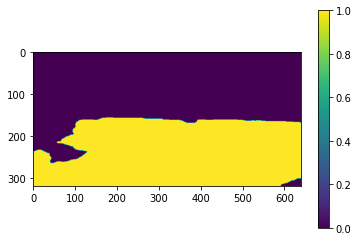

In [88]:
# r_mask = np.pad(r_mask, [-10,-10], 'constant')
plt.imshow(r_mask[10:h-10,10:w-10]); plt.colorbar()

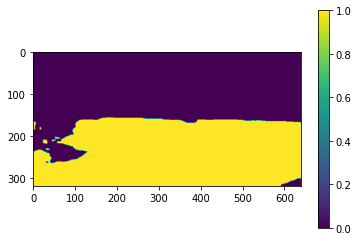

In [71]:
plt.imshow(masks[0]); plt.colorbar()

In [85]:
masks[0].shape

(320, 640)

In [30]:
import scipy.ndimage as ndimage    

# Create an empty image to store the masked array
r_mask = np.zeros_like(new, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

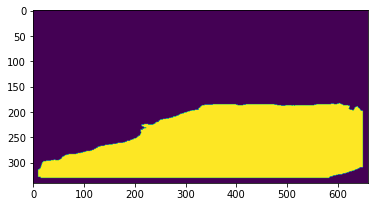

In [31]:
plt.imshow(r_mask)

In [15]:
from PIL import Image
import torchvision
import torchvision.transforms as T
import numpy as np


class torch_model:

    def __init__(self):
#         self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.eval()
        self.class_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
        self.threshold = 0.7
        self.input = 'RGB_Color'
        self.output = 'masks[ndarray],pred_boxes[list], pred_class[list]'
        self.model_name = 'maskrcnn_resnet50_fpn'
        self.description = 'Pretrained model from the torchvision library'
        
    def getInfo(self):
        self.info = {'name': self.model_name,
                     'input': self.input,
                     'output': self.output,
                     'classes': self.class_names,
                     'threshold': str(self.threshold),
                     'description': self.description}
        return self.info

    def image_prediction(self, img_path, threshold=0.7):
        img = Image.open(img_path)
        transform = T.Compose([T.ToTensor()])
        img = transform(img)
        pred = self.model([img])
        pred_score = list(pred[0]['scores'].detach().numpy())
        pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
        masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
        pred_class = [self.class_names[i] for i in list(pred[0]['labels'].numpy())]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
        if (len(masks.shape) == 3):
            masks = masks[:pred_t + 1]
        else:
            masks = np.expand_dims(masks, 0)
        pred_boxes = pred_boxes[:pred_t + 1]
        pred_class = pred_class[:pred_t + 1]
        return masks, pred_boxes, pred_class

In [16]:
model = torch_model()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/israel/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100.0%
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /home/israel/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100.0%


In [17]:
masks, boxes, classes = model.image_prediction('example.png')

AttributeError: 'list' object has no attribute 'shape'

In [5]:
classes

['person', 'person', 'person', 'person', 'bench']

In [14]:
classes

['person', 'person', 'person', 'person', 'bench']

In [17]:
from PIL import Image
import numpy as np
import colorsys

In [19]:
model = torch_model()

In [4]:
masks, _, class_names = model.image_prediction('example.png', 0.7)

In [9]:
img = Image.open('example.png')
img_array = np.array(img)

In [6]:
masks.shape

(5, 480, 720)

In [16]:
def random_colors(N, bright=True):
    """ Generate random colors """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image"""
    for c in range(3):
        image[:, :,
              c] = np.where(mask == 1, image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                            image[:, :, c])
    return image

def generate_mask(masked_image, masks):
    colors = random_colors(masks.shape[0])
    for i, color in enumerate(colors):
        masked_image = apply_mask(masked_image, masks[i], color, 0.5)
    return masked_image

In [10]:
masked = generate_mask(img_array, masks)

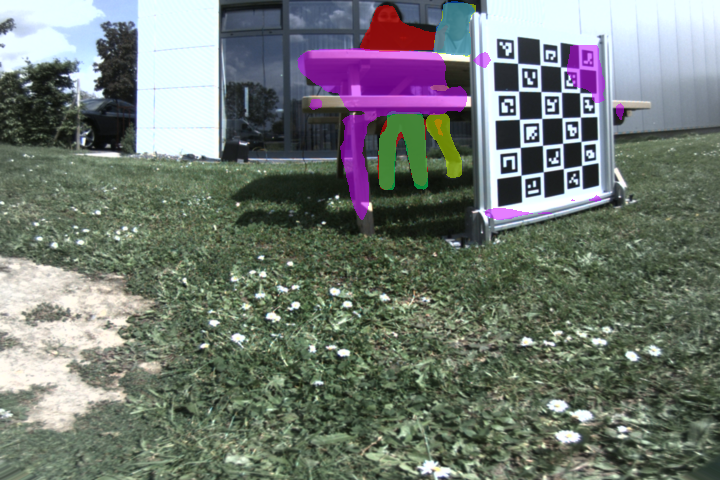

In [11]:
Image.fromarray(masked)

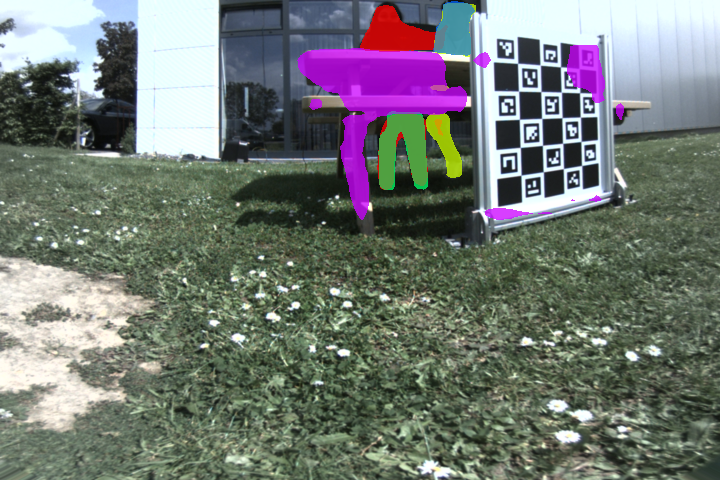

In [13]:
masked = generate_mask(img_array, masks)
Image.fromarray(masked)

In [24]:
import utils.misc as utils
import json

In [25]:
with open('example.json') as json_file:
        data = json.load(json_file)

In [34]:
annotations = data['annotations']
classes = list()
masks = list()
for instance in annotations:
    classes.append(instance['category'])
    masks.append(utils.rle2mask(instance['segmentation']))

In [37]:
np.array(masks).shape

(3, 480, 720)

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
from models.predict_torch import torch_model

In [17]:
model = torch_model()

In [5]:
_, bboxes, classes = model.get_prediction('example.png', 0.8)

In [11]:
bboxes

[[(350.10242, 3.5138948), (450.75668, 190.81865)],
 [(418.536, 3.151044), (476.4385, 177.3269)],
 [(375.18066, 99.57749), (432.2876, 190.67894)]]

In [7]:
classes

['person', 'person', 'person']

In [14]:
tuple([2,1,3])

(2, 1, 3)

# Mask to RLE 

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from models.predict_custom import custom_model

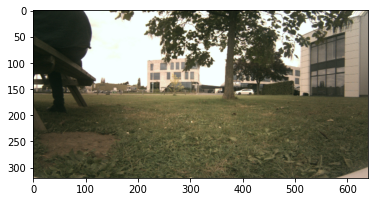

In [60]:
file = 'custom_new/rec22_color/000150.png'
img = Image.open(file)
plt.imshow(img)
plt.show()

In [61]:
model = custom_model()

In [62]:
# masks, bbox, classes = model.image_prediction(file)
masks, _, class_names = model.image_prediction(file)

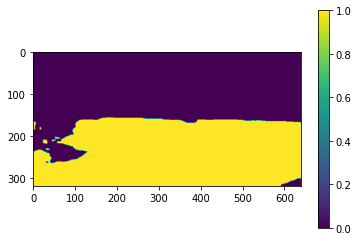

In [63]:
plt.imshow(masks[0]); plt.colorbar()
plt.show()

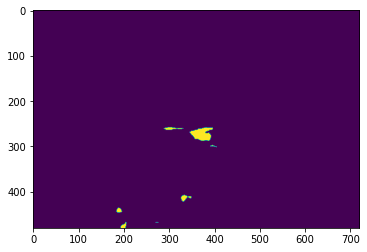

In [25]:
plt.imshow(np.argmax(pred[0], axis=0))

In [24]:
masked = generate_mask(np.array(img), masks)
Image.fromarray(masked)

NameError: name 'generate_mask' is not defined

In [10]:
masks[0].sum()

In [11]:
ground_truth_binary_mask.sum()

13

In [25]:
import json
import numpy as np
from pycocotools import mask
# from skimage import measure

ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)

In [26]:
rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
print(rle)

{'counts': [6, 1, 40, 4, 5, 4, 5, 4, 21], 'size': [9, 10]}


In [27]:
fortran_ground_truth_binary_mask

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [28]:
rle = binary_mask_to_rle(masks[0])
print(rle)

{'counts': [148, 112, 137, 83, 148, 112, 137, 83, 148, 112, 136, 84, 148, 112, 136, 84, 147, 112, 137, 84, 147, 112, 137, 84, 147, 112, 137, 84, 147, 112, 137, 84, 147, 112, 137, 84, 147, 111, 138, 84, 147, 111, 138, 16, 2, 66, 147, 111, 138, 14, 7, 63, 147, 111, 137, 14, 11, 60, 147, 111, 137, 15, 10, 60, 147, 111, 137, 15, 10, 60, 147, 111, 137, 16, 7, 62, 147, 111, 136, 18, 1, 67, 147, 111, 136, 86, 147, 111, 136, 86, 147, 111, 136, 86, 147, 112, 135, 86, 147, 112, 135, 86, 147, 112, 135, 86, 147, 112, 135, 86, 147, 113, 134, 86, 147, 113, 134, 86, 147, 113, 134, 86, 147, 113, 133, 87, 147, 113, 134, 9, 1, 76, 147, 113, 134, 9, 2, 75, 147, 113, 134, 8, 4, 74, 147, 113, 134, 8, 4, 74, 147, 113, 134, 6, 8, 72, 147, 114, 134, 5, 8, 72, 147, 114, 134, 4, 11, 70, 147, 114, 135, 2, 13, 69, 147, 115, 160, 58, 147, 115, 160, 58, 147, 115, 161, 57, 147, 116, 160, 57, 147, 116, 161, 56, 147, 116, 161, 56, 147, 116, 162, 55, 147, 117, 161, 55, 147, 117, 162, 54, 147, 117, 162, 54, 147, 117, 16

In [30]:
compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
new = mask.decode(compressed_rle)

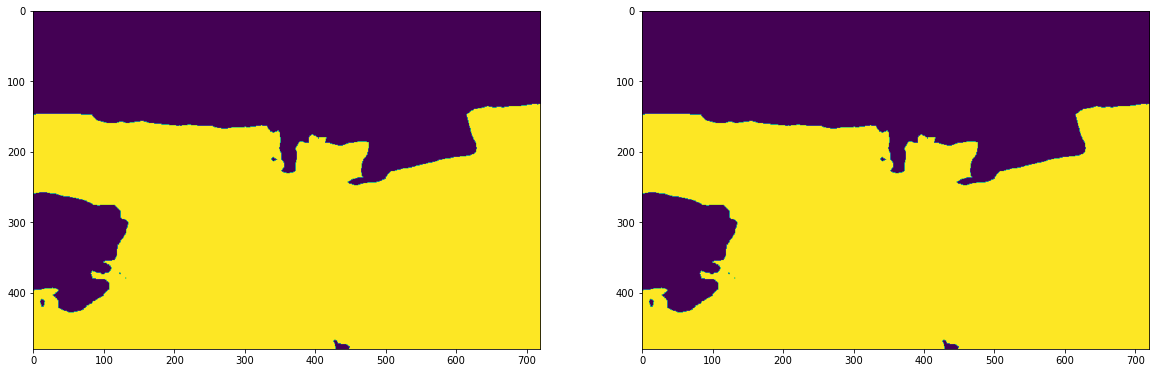

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(masks[0])
plt.subplot(1,2,2)
plt.imshow(new)
plt.show()

In [6]:
import json
from utils.misc import rle2mask
import matplotlib.pyplot as plt
import os


In [13]:

with open('example.json') as json_file:
    data = json.load(json_file)

In [20]:
annotations = data['annotations']

In [34]:
classes = list()
masks = list()
for instance in annotations:
    classes.append(instance['category'])
    masks.append(rle2mask(instance['segmentation']))

In [35]:
classes

['person', 'person', 'person', 'person', 'bench']

In [18]:
path = "/home/israel/Kobi/relabeller/example.png"

In [19]:
path_list = path.split('/')
path_list[-1] = path_list[-1].split('.')[0]+'.json'
os.path.join(*path_list)

'home/israel/Kobi/relabeller/example.json'

In [22]:
"/"+os.path.join(*path_list)

'/home/israel/Kobi/relabeller/example.json'

Testing superpixel segmentation

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from PIL import Image

In [12]:
img = Image.open('example.png')
img = np.array(img)
# img = img_as_float(astronaut()[::2, ::2])

Felzenszwalb number of segments: 1094
SLIC number of segments: 125
Quickshift number of segments: 462


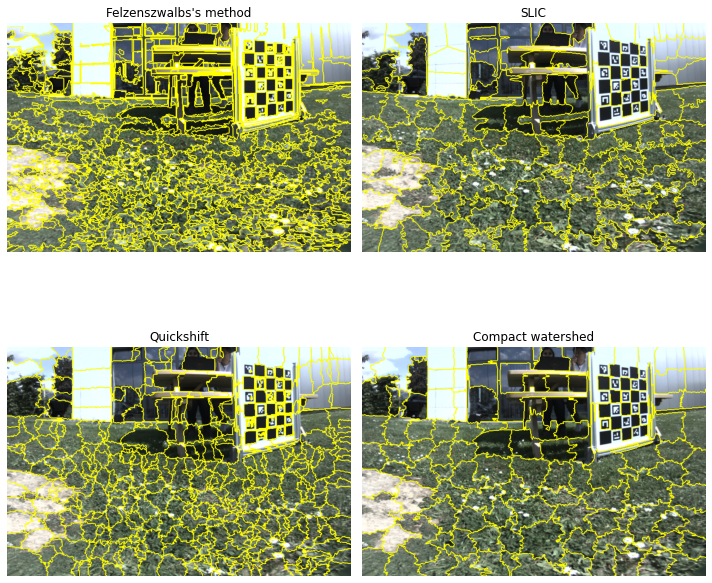

In [15]:

# segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=200, compactness=10, sigma=1,
                     start_label=1)
# segments_quick = quickshift(img, kernel_size=7, max_dist=6, ratio=0.1)
# gradient = sobel(rgb2gray(img))
# segments_watershed = watershed(gradient, markers=150, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [34]:
segments_slic = slic(img, n_segments=200, compactness=20, sigma=1,
                     start_label=1)

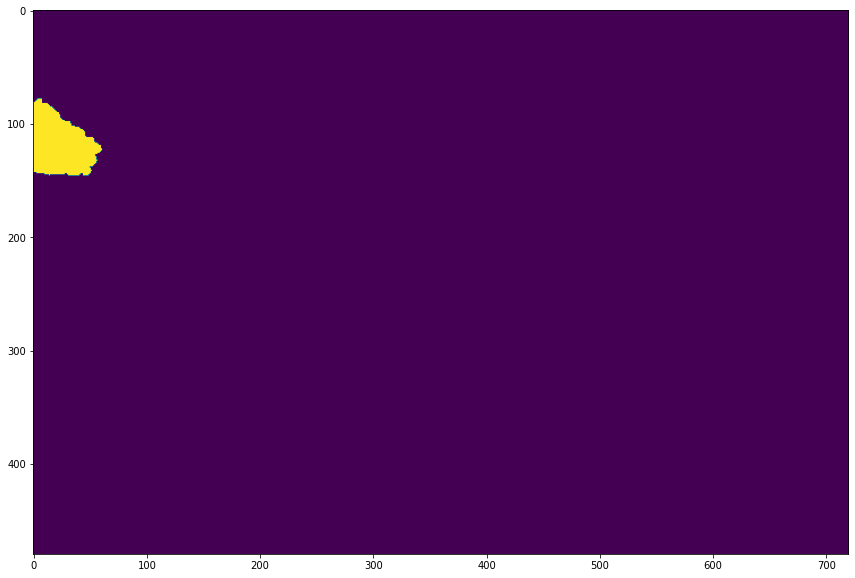

In [60]:
plt.figure(figsize=(15,10))
plt.imshow(segments_slic == 33)

In [62]:
(segments_slic == 33)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

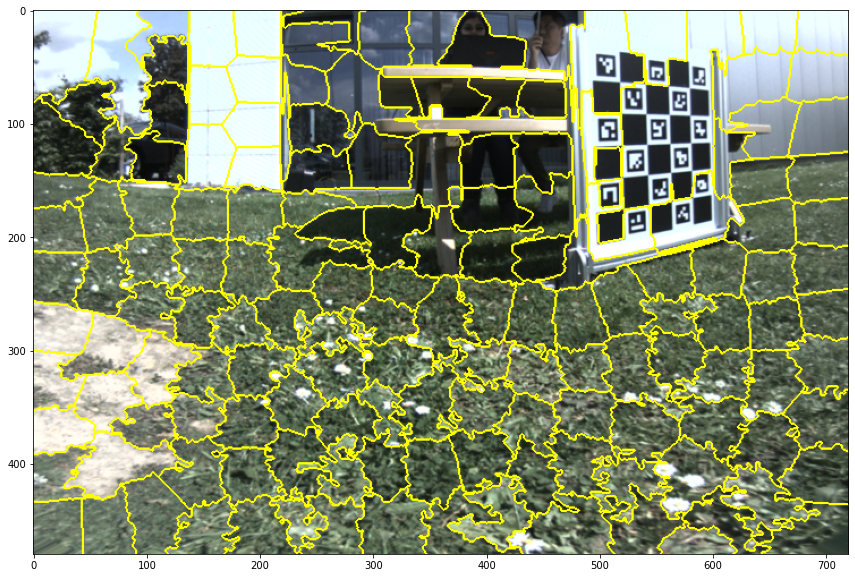

In [39]:
plt.figure(figsize=(15,10))
plt.imshow()

In [43]:
from models.predict_custom import custom_model
model = custom_model()

In [44]:
mask, _, classes = model.image_prediction('example.png')

In [49]:
img = Image.open('example.png')

In [50]:
img.size

(720, 480)

Testing cursor animation

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, draw
from skimage import measure
sys.executable

ImportError: cannot import name 'draw' from 'PIL' (/home/israel/Venvs/test/lib/python3.8/site-packages/PIL/__init__.py)

In [82]:
icon = Image.open('icons/pen.png')
icon = icon.convert("RGBA")
icon

(64, 64)

In [96]:
img = Image.open('icons/pen.png').convert("RGBA")
np.array(img).shape

(64, 64, 4)

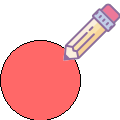

In [110]:
from PIL import Image, ImageDraw

image = Image.new('RGBA', (120, 120))
draw = ImageDraw.Draw(image)
# draw.ellipse((20, 180, 180, 20), fill = 'blue', outline ='blue')
draw.ellipse((0, 40, 80, 120), fill = (255,0,0,150), outline ='black')
image.paste(icon, (60,0), icon)
image

In [78]:
np.array(image).shape

(150, 150, 4)

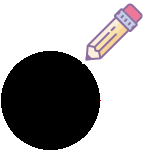

In [71]:
image

In [2]:
from models.predict_torch import torch_model
model = torch_model()
from models.predict_custom import custom_model
custom = custom_model()

In [10]:
ls

example.png  icons/   models/    test.ipynb  utils/
examples/    main.py  README.md  test.py


In [2]:
img_path = "example.png"

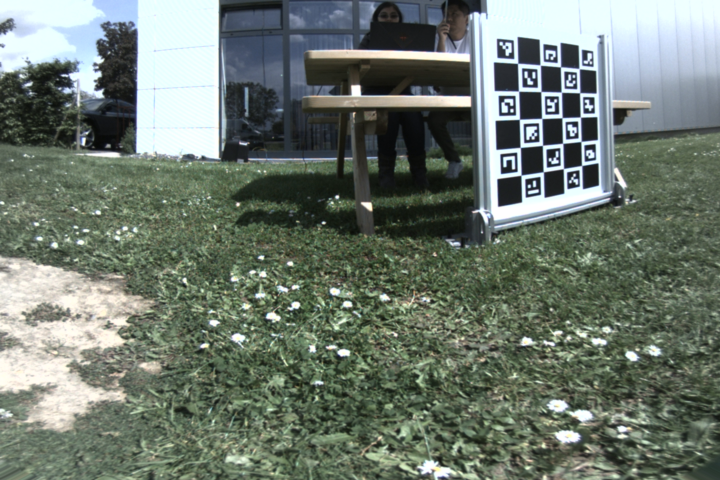

In [4]:
img = Image.open(img_path)
img

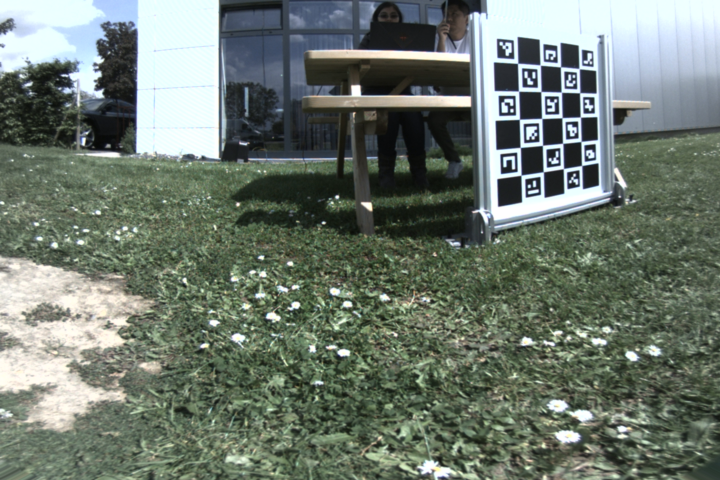

In [5]:
from PIL import ImageEnhance

#read the image
im = Image.open(img_path)

#image brightness enhancer
enhancer = ImageEnhance.Brightness(im)

factor = 1 #gives original image
im_output = enhancer.enhance(factor)
im_output
# im_output.save('original-image.png')

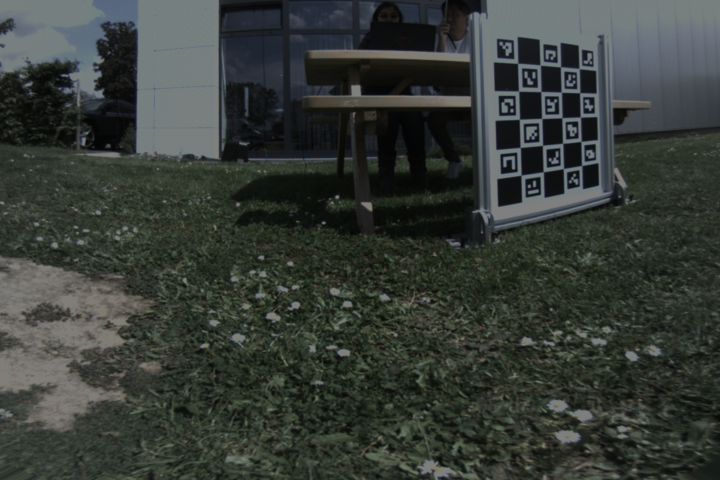

In [13]:
factor = 0.5 #darkens the image
im_output = enhancer.enhance(factor)
im_output
# im_output.save('darkened-image.png')

In [17]:
np.array(im_output).shape

(480, 720, 3)

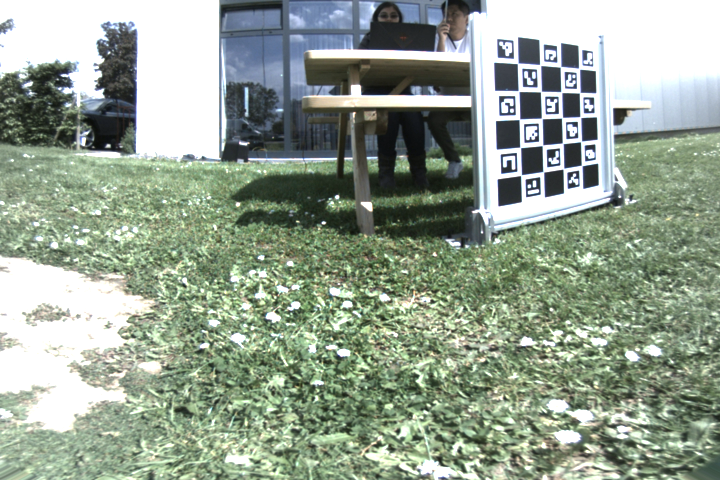

In [12]:
factor = 1.5 #brightens the image
im_output = enhancer.enhance(factor)
im_output
# im_output.save('brightened-image.png')

In [4]:
masks, bbox, classes = model.get_prediction(img_path, 0.5)

In [5]:
masks2, _, labels = custom.image_prediction(img_path)

In [7]:
classes

['person', 'person', 'person', 'person', 'bench', 'person', 'car', 'person']

In [77]:
for i, (box, label, col)  in enumerate(zip(bbox,classes, color)):
    x1, y1 = box[0]
    x2, y2 = box[1]
    x, y, w, h = int(x1), int(y1), int(x2 - x1), int(y2 - y1)
    print(x, y, w, h, label, list([c*255 for c in col]), i)

350 3 100 187 person [255.0, 0.0, 0.0] 0
418 3 57 174 person [255.0, 255.0, 0.0] 1
375 99 57 91 person [0.0, 255.0, 0.0] 2
432 0 42 56 person [0.0, 255.0, 255.0] 3
295 37 343 185 bench [0.0, 0.0, 255.0] 4
358 0 47 191 person [255.0, 0.0, 255.0] 5


In [34]:
from utils.change import map_image

In [39]:
mimage = map_image('example.png')

In [47]:
color = mimage.random_colors(6)

In [85]:
classes

['person', 'person', 'person', 'person', 'bench', 'person', 'person']

In [84]:
classes.remove('car')

In [15]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure

In [27]:
ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   1,   1,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(masks[0])
encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
ground_truth_area = mask.area(encoded_ground_truth)
ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
contours = measure.find_contours(ground_truth_binary_mask, 0.5)

In [28]:
contours

[array([[ 84.5, 489. ],
        [ 84.5, 488. ],
        [ 84.5, 487. ],
        [ 84.5, 486. ],
        [ 84.5, 485. ],
        [ 84.5, 484. ],
        [ 84.5, 483. ],
        [ 84.5, 482. ],
        [ 84.5, 481. ],
        [ 84.5, 480. ],
        [ 84.5, 479. ],
        [ 84.5, 478. ],
        [ 84.5, 477. ],
        [ 84.5, 476. ],
        [ 84.5, 475. ],
        [ 84.5, 474. ],
        [ 84.5, 473. ],
        [ 84.5, 472. ],
        [ 84.5, 471. ],
        [ 84.5, 470. ],
        [ 84.5, 469. ],
        [ 84.5, 468. ],
        [ 84. , 467.5],
        [ 83. , 467.5],
        [ 82. , 467.5],
        [ 81.5, 468. ],
        [ 81.5, 469. ],
        [ 81.5, 470. ],
        [ 81.5, 471. ],
        [ 81.5, 472. ],
        [ 81.5, 473. ],
        [ 81.5, 474. ],
        [ 81.5, 475. ],
        [ 81.5, 476. ],
        [ 81.5, 477. ],
        [ 81.5, 478. ],
        [ 81.5, 479. ],
        [ 81.5, 480. ],
        [ 81.5, 481. ],
        [ 81.5, 482. ],
        [ 81.5, 483. ],
        [ 81.5, 

In [29]:
for contour in contours:
    contour = np.flip(contour, axis=1)
    print(contour)
    segmentation = contour.ravel().tolist()

[[489.   84.5]
 [488.   84.5]
 [487.   84.5]
 [486.   84.5]
 [485.   84.5]
 [484.   84.5]
 [483.   84.5]
 [482.   84.5]
 [481.   84.5]
 [480.   84.5]
 [479.   84.5]
 [478.   84.5]
 [477.   84.5]
 [476.   84.5]
 [475.   84.5]
 [474.   84.5]
 [473.   84.5]
 [472.   84.5]
 [471.   84.5]
 [470.   84.5]
 [469.   84.5]
 [468.   84.5]
 [467.5  84. ]
 [467.5  83. ]
 [467.5  82. ]
 [468.   81.5]
 [469.   81.5]
 [470.   81.5]
 [471.   81.5]
 [472.   81.5]
 [473.   81.5]
 [474.   81.5]
 [475.   81.5]
 [476.   81.5]
 [477.   81.5]
 [478.   81.5]
 [479.   81.5]
 [480.   81.5]
 [481.   81.5]
 [482.   81.5]
 [483.   81.5]
 [484.   81.5]
 [485.   81.5]
 [486.   81.5]
 [487.   81.5]
 [488.   81.5]
 [489.   81.5]
 [490.   81.5]
 [491.   81.5]
 [491.5  82. ]
 [491.5  83. ]
 [491.   83.5]
 [490.   83.5]
 [489.5  84. ]
 [489.   84.5]]
[[  0.  145.5]
 [  1.  145.5]
 [  2.  145.5]
 ...
 [717.  134.5]
 [718.  134.5]
 [719.  134.5]]
[[299.  148.5]
 [298.  148.5]
 [297.  148.5]
 [296.  148.5]
 [295.  148.5]
 [2

In [11]:
nimg = np.array(img)

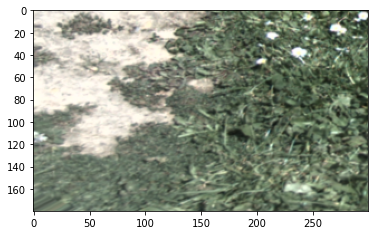

In [15]:
plt.imshow(nimg[300:480,0:300,:])
plt.show()

In [14]:
import colorsys
import random
import numpy as np
import PIL
from PIL import Image, ImageChops, ImageFilter

In [26]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def generate_mask(img_path):
    masks, _, classes = model.get_prediction(img_path, 0.5)
    img = Image.open(img_path)
    img = np.array(img)
    colors = random_colors(len(classes))
    masked_image = img.copy()
    for i in range(len(classes)):
        masked_image = apply_mask(masked_image, masks[i], colors[i])
        
    return masked_image

In [87]:
colors = random_colors(len(classes))
masked_image = img.copy()
for i in range(len(classes)):
    masked_image = apply_mask(masked_image, masks[i], colors[i])

In [88]:
color = random_colors(1)

In [66]:
result = apply_mask(img, masks[0],color[0])

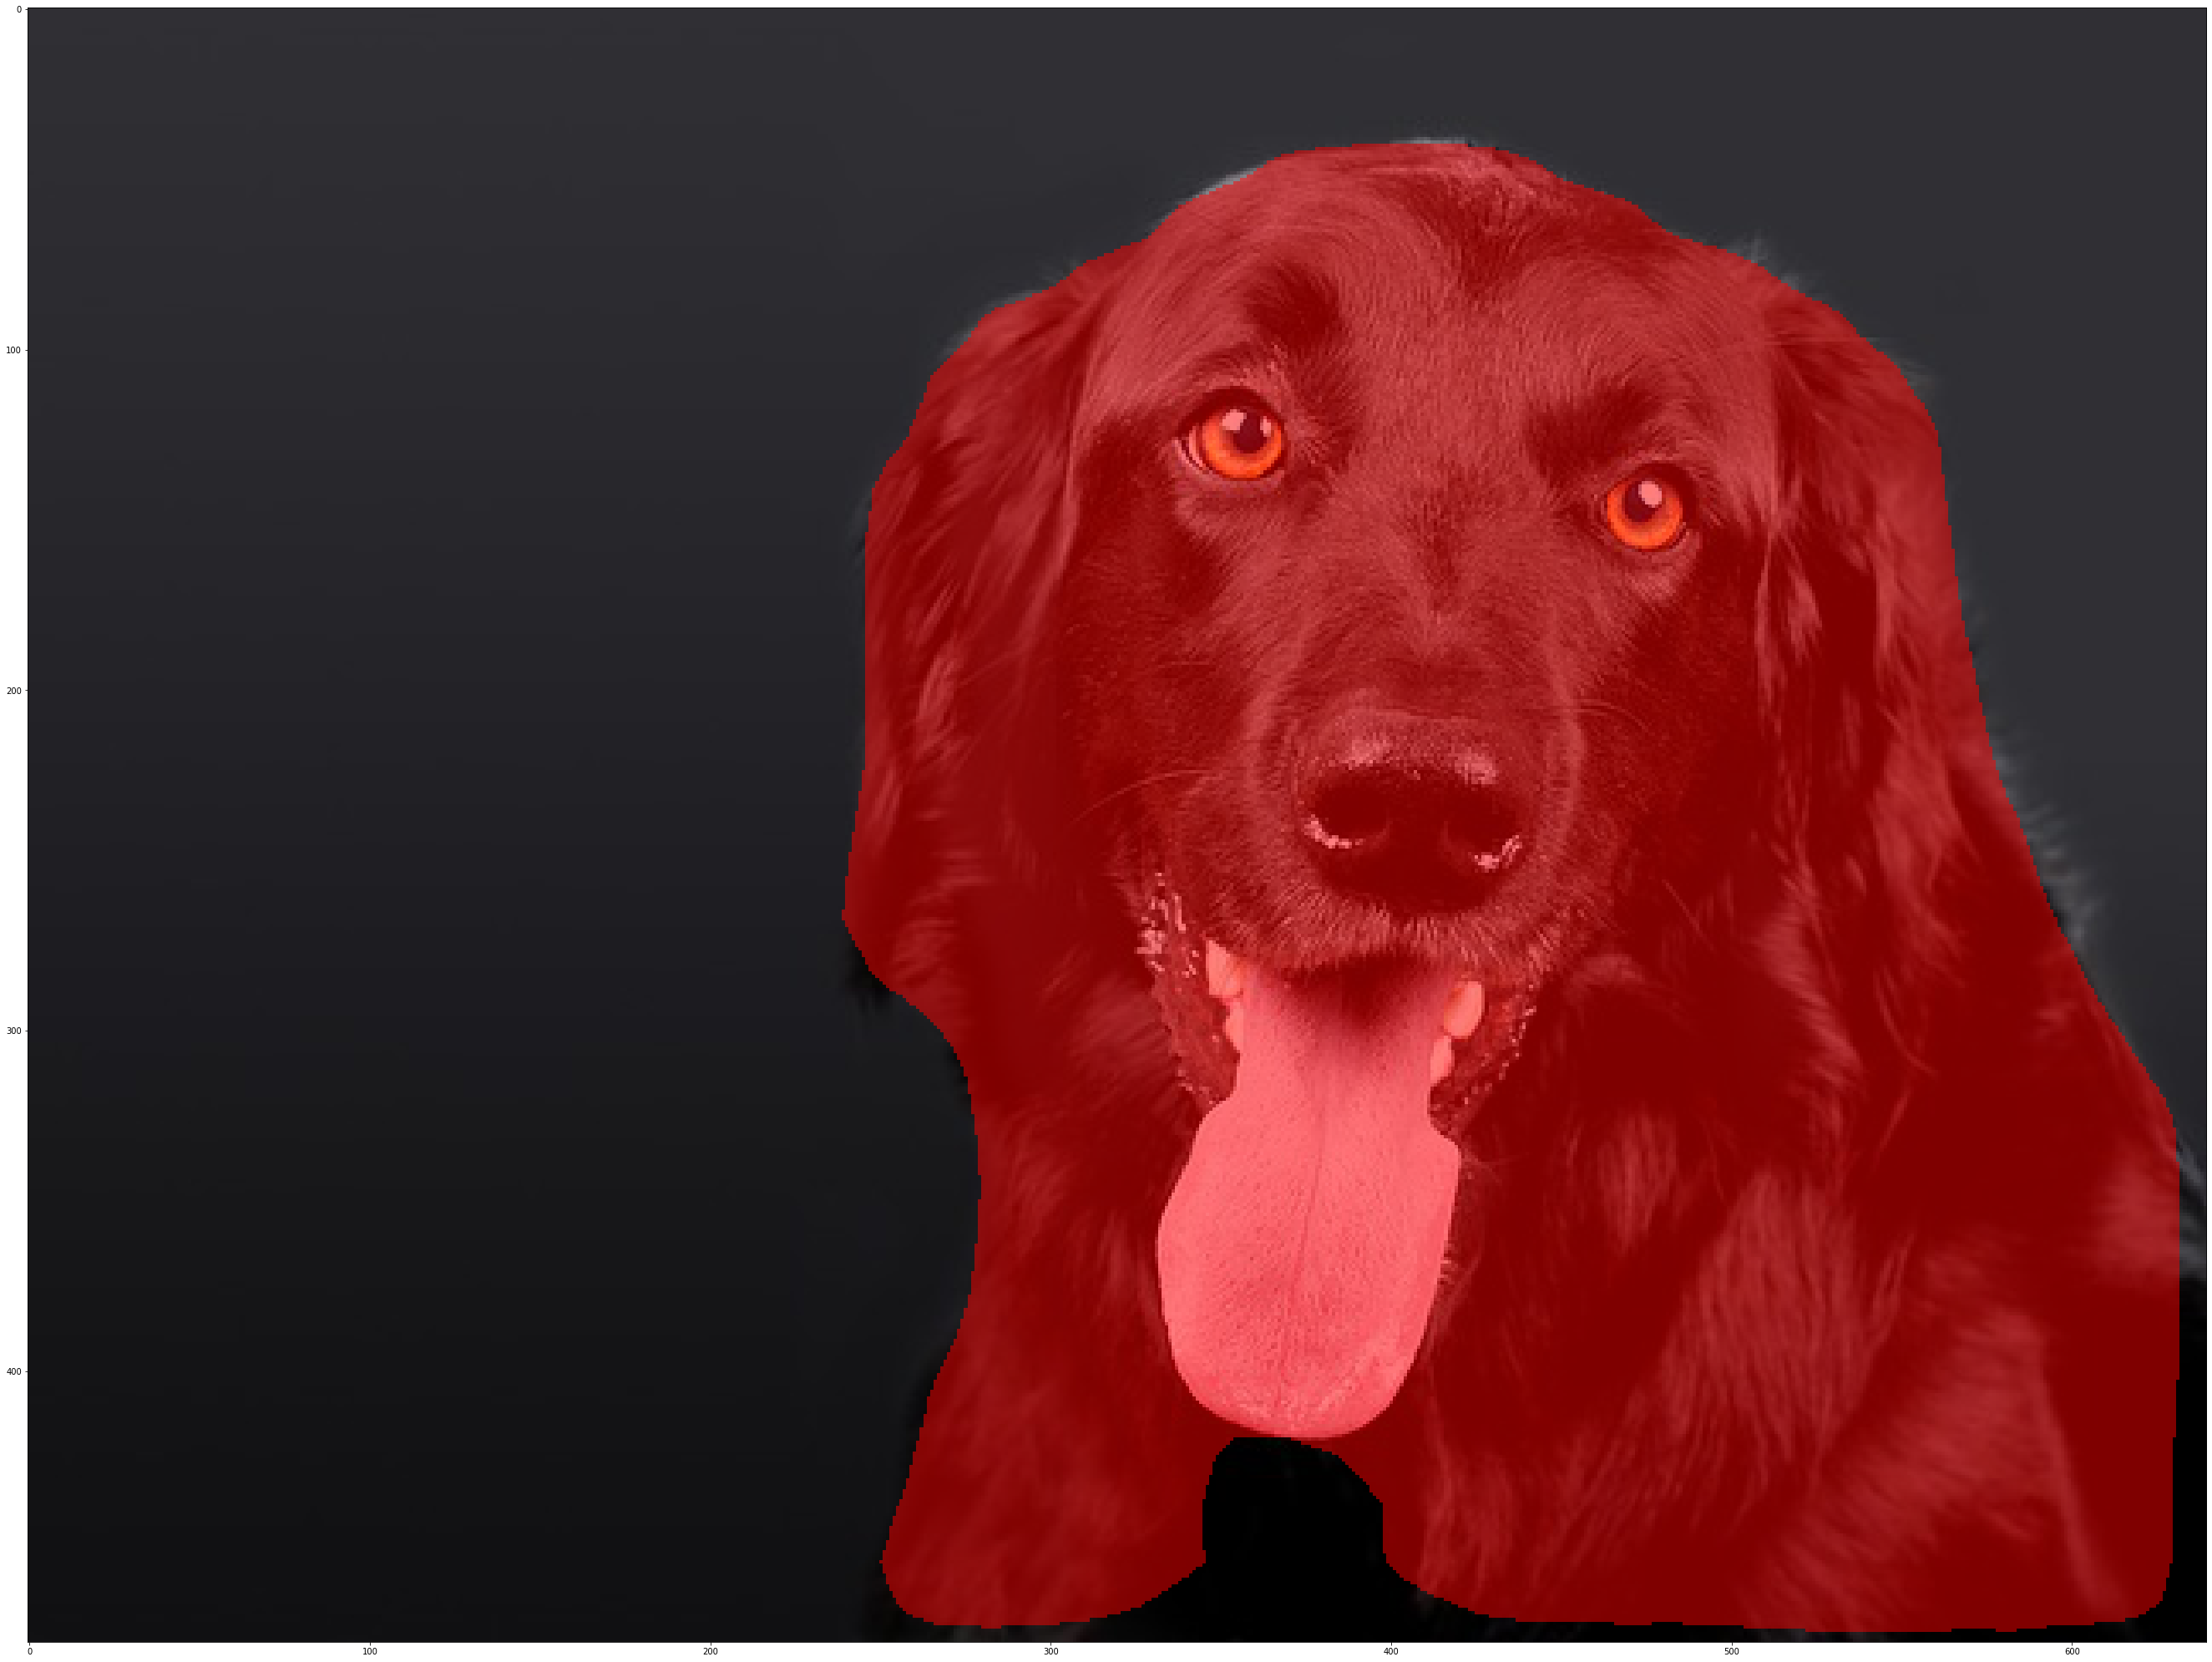

In [89]:
plt.figure(figsize=(48,36))
plt.imshow(masked_image)
plt.show()

In [12]:
import sys
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
# model architecture
from models.fscnn2 import FSCNN

In [7]:
# Specify a path
PATH = 'models/e_0059_vl_19550.4_pa_0.978_iou_0.953.pth'

model = FSCNN(num_classes=2)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
_ = model.eval()

In [13]:
im_path  = 'models/images/000012_yuv_1.png'

img = Image.open(im_path)
ycbcr = img.convert('YCbCr')
transform = T.Compose([T.ToTensor()])
img = transform(ycbcr)
img = img.unsqueeze(0)
pred = model(img)

In [22]:
predictions = pred.data.max(1)[1].squeeze_(1).cpu().numpy()

Fitting model on a small sub-sample of the data
done in 0.047s.
Predicting color indices on the full image (k-means)
done in 0.003s.
Predicting color indices on the full image (random)
done in 0.005s.


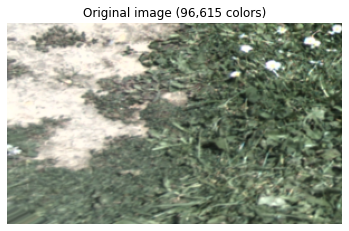

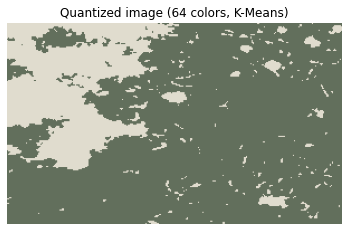

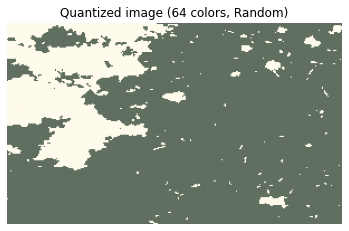

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 2

# Load the Summer Palace photo
china = nimg[300:480,0:300,:]

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

In [26]:
from PIL import ImageOps

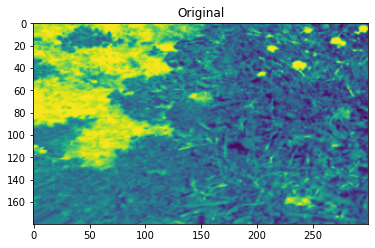

In [28]:
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
# Scaling the image pixels values within 0-1
# img = imread('roi.jpg') / 255
img = nimg[300:480,0:300,:]
img = ImageOps.grayscale(Image.fromarray(img)) 
plt.imshow(img)
plt.title('Original')
plt.show()

In [29]:
# For clustering the image using k-means, we first need to convert it into a 2-dimensional array
image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
# Use KMeans clustering algorithm from sklearn.cluster to cluster pixels in image
from sklearn.cluster import KMeans
# tweak the cluster size and see what happens to the Output
kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]
# Reshape back the image from 2D to 3D image
clustered_3D = clustered.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(clustered_3D)
plt.title('Clustered Image')
plt.show()

AttributeError: 'Image' object has no attribute 'reshape'

In [30]:
clustered_3D[:,:,0].shape

(180, 300)

In [31]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage import io

orig_phantom = img_as_ubyte(clustered_3D[:,:,0])
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

ValueError: Images of type float must be between -1 and 1.

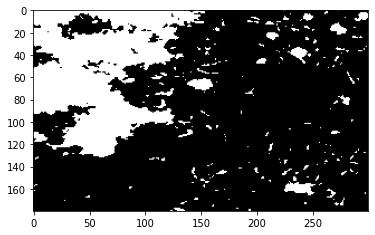

In [32]:
orig_phantom = clustered_3D[:,:,0]
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

In [33]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [34]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

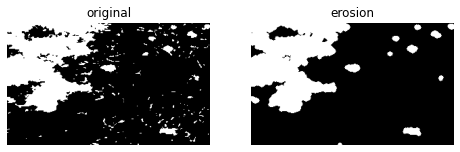

In [35]:
selem = disk(3)
eroded = erosion(orig_phantom, disk(2))
dilated = dilation(eroded, disk(3))
plot_comparison(orig_phantom, dilated, 'erosion')

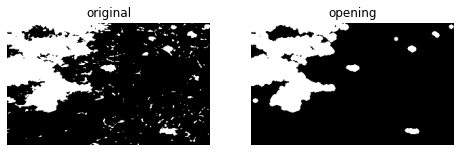

In [36]:
opened = opening(orig_phantom, selem)
plot_comparison(orig_phantom, opened, 'opening')

In [38]:
opened

array([[222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       [222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       [222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       ...,
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845],
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845],
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845]])

In [39]:
dilated

array([[222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       [222.32686209, 222.32686209, 222.32686209, ..., 222.32686209,
        222.32686209, 100.14328845],
       [222.32686209, 222.32686209, 222.32686209, ..., 222.32686209,
        222.32686209, 222.32686209],
       ...,
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845],
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845],
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845]])

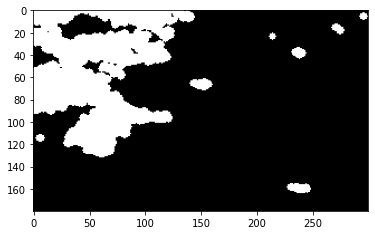

In [40]:
plt.imshow(opened, 'gray')
plt.show()

In [41]:
opened

array([[222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       [222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       [222.32686209, 222.32686209, 222.32686209, ..., 100.14328845,
        100.14328845, 100.14328845],
       ...,
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845],
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845],
       [100.14328845, 100.14328845, 100.14328845, ..., 100.14328845,
        100.14328845, 100.14328845]])

In [194]:
histogram, bin_edges = np.histogram(opened, bins=256, range=(0, 1))


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

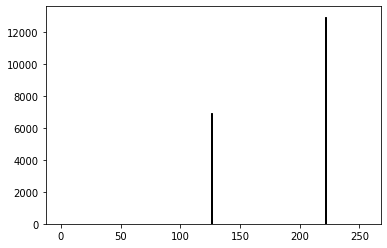

In [195]:
plt.hist(opened.ravel(), bins=256, range=(0.0, 255.0), fc='k', ec='k')


In [196]:
mask = opened
mask[opened>200]=True
mask[opened<=200]=False

In [211]:
print(mask)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [214]:
mask = np.where(dilated> 200, 0, 1)

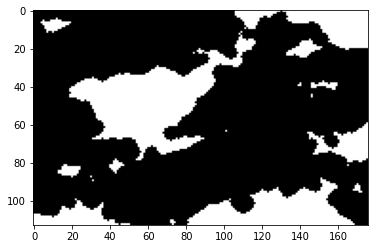

In [215]:
plt.imshow(mask, 'gray')
plt.show()

In [42]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

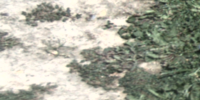

In [46]:
# image = Image.open('roi.jpg')
image = Image.fromarray(nimg[300:400,:200,])
image

In [51]:
from utils.change import map_image
model = map_image('example.png')

In [54]:
mask_roi = model.roi_prediction(np.array(image))

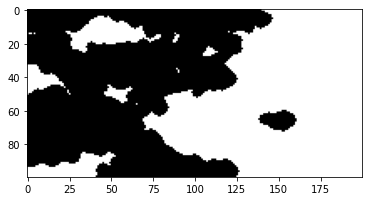

In [55]:
plt.imshow(mask_roi, 'gray')
plt.show()

In [56]:
mask_roi.astype('bool') * mask_roi.astype('bool')

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [62]:
mask_roi[0,0], mask_roi[0,-1], mask_roi[-1,0], mask_roi[-1,-1]

(False, True, True, True)

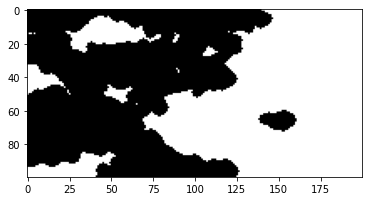

In [63]:
img = np.array(image)/255
image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]
clustered_3D = clustered.reshape(img.shape[0], img.shape[1], img.shape[2])
gray = img_as_ubyte(clustered_3D[:,:,0])
selem = disk(3)
eroded = erosion(gray, disk(2))
dilated = dilation(eroded, disk(3))
mask = np.where(dilated> 200, 0, 1)
# return mask.astype('bool')
plt.imshow(mask, 'gray')
plt.show()

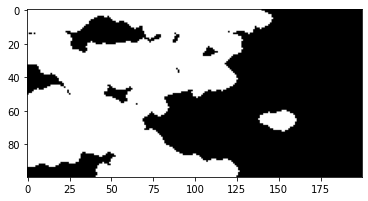

In [64]:
plt.imshow(dilated, 'gray')
plt.show()

In [2]:
from predict_custom import custom_model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_path = '/home/israel/repos/relabeller/models/images/000007_yuv_1.png'

In [4]:
model = custom_model(img_path)

TypeError: __init__() takes 1 positional argument but 2 were given

In [12]:
import scipy.misc
import numpy as np
from skimage.draw import line_aa
from PIL import Image
import aggdraw

In [17]:
img = np.zeros((1000, 1000), dtype=np.uint8)
rr, cc, val = line_aa(1, 1, 80, 44)
img[rr, cc] = val * 255

In [5]:
import matplotlib.pyplot as plt

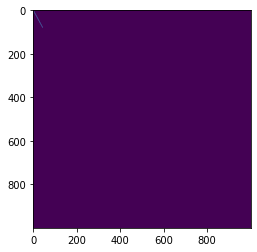

In [18]:
plt.imshow(img)
plt.show()

In [128]:
test = np.zeros((1000, 1000), dtype=np.uint8)

In [113]:
test.shape

(1000, 1000)

In [160]:
d = aggdraw.Draw(img)
p = aggdraw.Pen(color="white", width= 10, opacity=20, linecap=0)
# d.line((0, 0, 500, 500), p)
d.line((20, 200, 200, 20), p)
d.flush()

TypeError: Pen() takes at most 3 keyword arguments (4 given)

In [141]:
img = Image.fromarray(final*255)

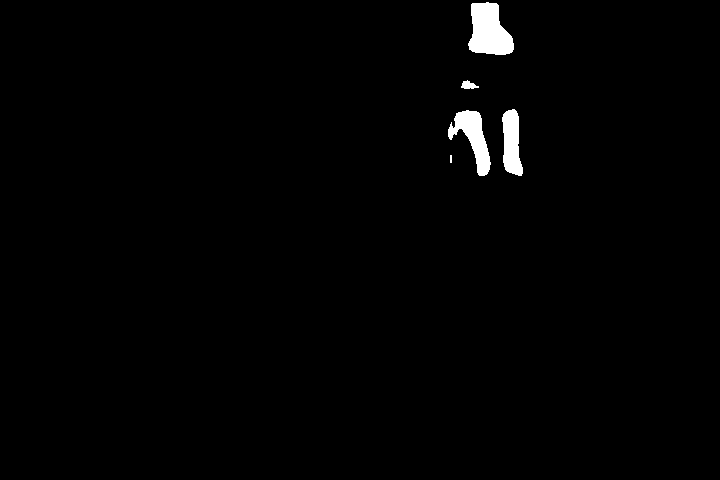

In [142]:
img

In [98]:
rgbimg = Image.new("RGB", img.size)
rgbimg.paste(img)

In [138]:
final = masks[0].astype('uint8')

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cd ~/Downloads/segmentation/2/images/

/home/israel/Downloads/segmentation/2/images


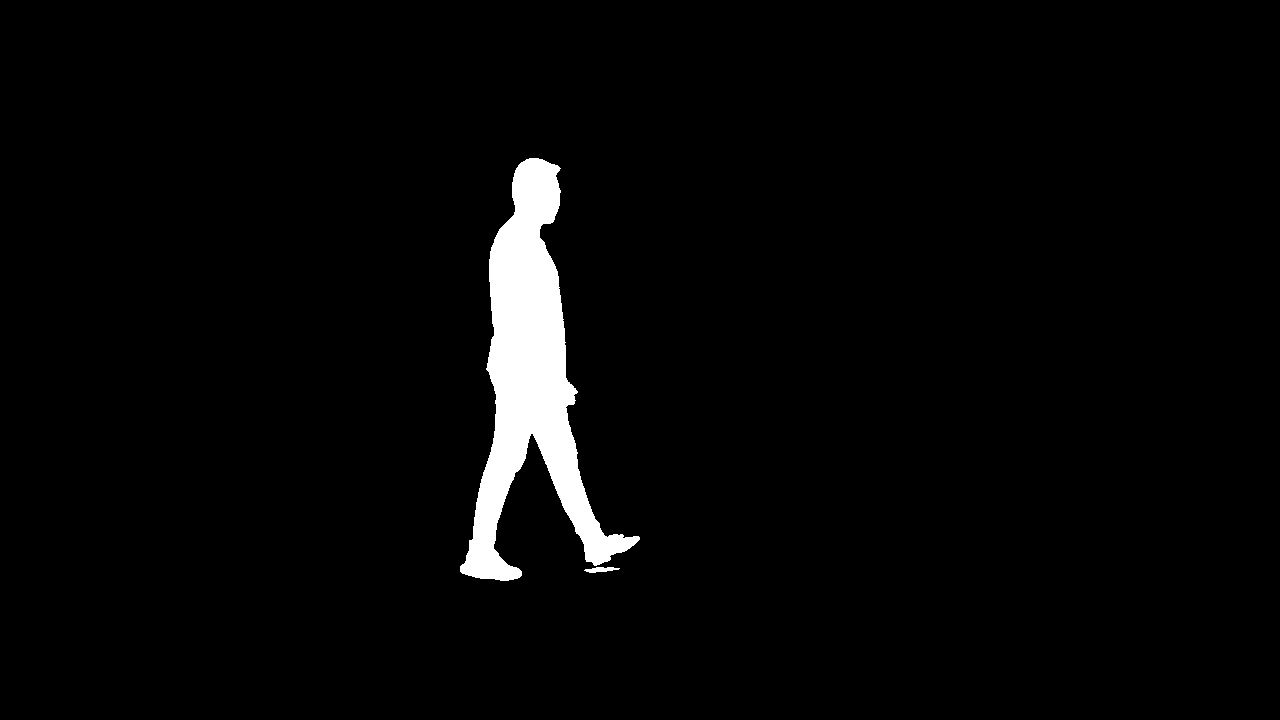

In [44]:
path = 'masks/002_0209.png'
img = Image.open(path)
img

In [45]:
np.array(img).shape

(720, 1280)

In [14]:
nimag = np.array(img)[np.newaxis].astype('bool')

In [46]:
plt.imsave('test.jpg', nimag[0].astype('uint8')*255, cmap ='gray')

In [36]:
(nimag[0].astype('uint8')*255).shape

(720, 1280)

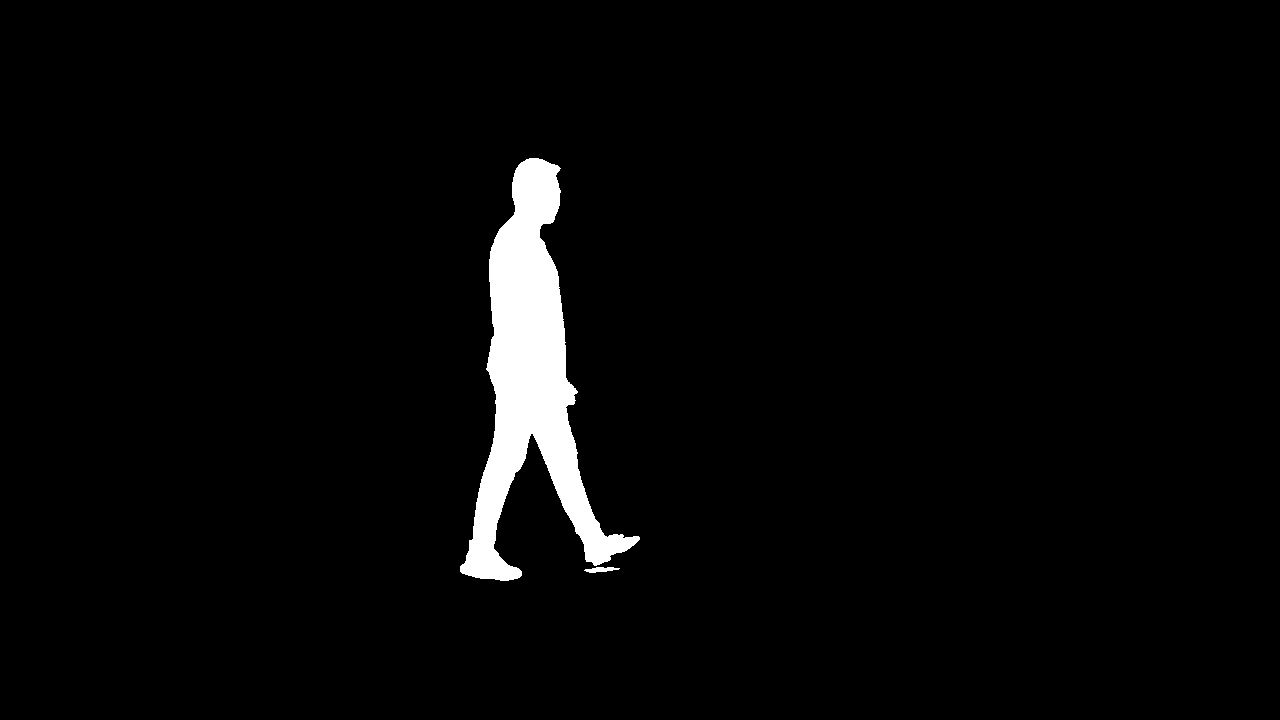

In [56]:
imgplt = Image.open('filename.png')
imgplt

In [57]:
np.array(imgplt).shape

(720, 1280)